Student: Dorin Doncenco

Use the binarized MNIST database to:

·        Generate images with autoregressive models available in the pytorch library

·        What are the encountered difficulties (initialization…)

·        Comment on the obtained results according to the used settings 


In [2]:
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib
import math


import dataset_loader

%matplotlib inline

mnist_path = "./mnist.pkl.gz"

# the dataset contains 3 splits (train/dev/test),
# each one containing two vectors (pixels and classes)
(train_data_pixels, train_data_classes), \
(dev_data_pixels, dev_data_classes), _ = dataset_loader.load_mnist(mnist_path)

#convert data to pytorch tensors
train_data_pixels = torch.from_numpy(train_data_pixels)
train_data_classes = torch.from_numpy(train_data_classes)
dev_data_pixels = torch.from_numpy(dev_data_pixels)
dev_data_classes = torch.from_numpy(dev_data_classes)

## Masked Autoencoder for Distribution Estimation (MADE)

The MADE architecture uses a internal mask to learn mappings of the order of the dependencies in the time-series i.e. $ (x_3, x_1, x_2) \rightarrow p(x_3) $ doesn't depend on any input, $ p(x_1 | x_3), p(x_2 | x_3, x_1) $

In [3]:
class MaskedLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """

    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)


class MADE(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.nin = 784 #28 * 28
        self.nout = 784
        self.hidden_sizes = [512, 512, 512]
        self.device = device

        # define a simple MLP neural net
        self.net = []
        hs = [self.nin] + self.hidden_sizes + [self.nout]
        for h0, h1 in zip(hs, hs[1:]):
            self.net.extend([
                MaskedLinear(h0, h1),
                nn.ReLU(),
            ])
        self.net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*self.net).to(device)

        self.m = {}
        self.create_mask()  # builds the initial self.m connectivity

    def create_mask(self):
        L = len(self.hidden_sizes)

        # sample uniform distribution the order of the inputs and the connectivity of all neurons
        self.m[-1] = np.arange(self.nin)
        for l in range(L):
            self.m[l] = np.random.randint(self.m[l - 1].min(), self.nin - 1, size=self.hidden_sizes[l])

        # construct the mask matrices
        masks = [self.m[l - 1][:, None] <= self.m[l][None, :] for l in range(L)]
        masks.append(self.m[L - 1][:, None] < self.m[-1][None, :])

        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l, m in zip(layers, masks):
            l.set_mask(m)

    def nll(self, x):
        x = x.view(-1, 784).to(self.device) # Flatten image
        logits = self.net(x)
        return F.binary_cross_entropy_with_logits(logits, x)

    def sample(self, n):
        samples = torch.zeros(n, 784).to(self.device)
        with torch.no_grad():
            for i in range(784):
                logits = self.net(samples)[:, i]
                probs = torch.sigmoid(logits)
                samples[:, i] = torch.bernoulli(probs)
            samples = samples.view(n, 1, 28, 28)
        return samples.cpu()

In [4]:
# Training

def train(model, train_data_pixels, dev_data_pixels, batch_size, epochs, lr, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    dev_losses = []
    for epoch in range(epochs):
        model.train()
        for i in range(0, train_data_pixels.shape[0], batch_size):
            batch = train_data_pixels[i:i + batch_size]
            loss = model.nll(batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_losses.append(loss.item())
        model.eval()
        dev_losses.append(model.nll(dev_data_pixels).item())
        print(f"Epoch {epoch} train loss: {train_losses[-1]} dev loss: {dev_losses[-1]}")
    return train_losses, dev_losses

def plot_losses(train_losses, dev_losses):
    plt.plot(train_losses, label="train loss")
    plt.plot(dev_losses, label="dev loss")
    plt.legend()
    plt.show()

def plot_samples(samples):
    fig, axes = plt.subplots(4, 4, figsize=(4, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i, 0], cmap='gray')
        ax.axis('off')
    plt.show()

def plot_samples_grid(samples):
    fig, axes = plt.subplots(4, 4, figsize=(4, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i], cmap='gray')
        ax.axis('off')
    plt.show()


Epoch 0 train loss: 0.2527049481868744 dev loss: 0.2506740391254425
Epoch 1 train loss: 0.22611482441425323 dev loss: 0.2248319834470749
Epoch 2 train loss: 0.20967504382133484 dev loss: 0.20781666040420532
Epoch 3 train loss: 0.19659921526908875 dev loss: 0.19479484856128693
Epoch 4 train loss: 0.1857663244009018 dev loss: 0.18440426886081696
Epoch 5 train loss: 0.17701755464076996 dev loss: 0.17548227310180664
Epoch 6 train loss: 0.17006468772888184 dev loss: 0.16801941394805908
Epoch 7 train loss: 0.16369691491127014 dev loss: 0.16147682070732117
Epoch 8 train loss: 0.15805119276046753 dev loss: 0.15595589578151703
Epoch 9 train loss: 0.1537618488073349 dev loss: 0.15167051553726196
Epoch 10 train loss: 0.15001972019672394 dev loss: 0.14807040989398956
Epoch 11 train loss: 0.14704640209674835 dev loss: 0.14510083198547363
Epoch 12 train loss: 0.14467909932136536 dev loss: 0.14264754951000214
Epoch 13 train loss: 0.14240731298923492 dev loss: 0.14042332768440247
Epoch 14 train loss: 

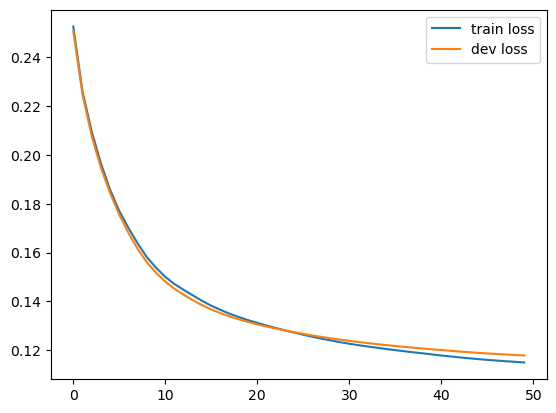

In [25]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MADE(device)
train_losses, dev_losses = train(model, train_data_pixels, dev_data_pixels, batch_size=128, epochs=50, lr=5e-4, device=device)
plot_losses(train_losses, dev_losses)


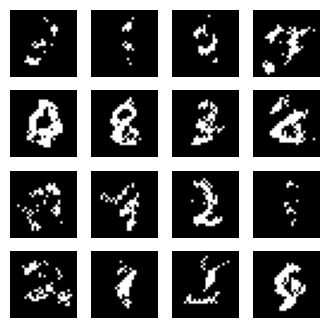

In [27]:
# Sampling
samples = model.sample(16)
plot_samples(samples)


The images generated represent various digits, however they contain some faults in generation.